<a href="https://colab.research.google.com/github/WilliamAshbee/splineexample/blob/main/SimplestToyProblem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

tensor(0.) tensor(0.)
tensor(0.) tensor(1.)
tensor(0.) tensor(2.)
tensor(0.) tensor(3.)
tensor(0.) tensor(4.)
tensor(0.) tensor(5.)
tensor(0.) tensor(6.)
tensor(0.) tensor(7.)
tensor(0.) tensor(8.)
tensor(0.) tensor(9.)
tensor(0.) tensor(10.)
tensor(0.) tensor(11.)
tensor(0.) tensor(12.)
tensor(0.) tensor(13.)
tensor(0.) tensor(14.)
tensor(0.) tensor(15.)
tensor(0.) tensor(16.)
tensor(0.) tensor(17.)
tensor(0.) tensor(18.)
tensor(0.) tensor(19.)
tensor(0.) tensor(20.)
tensor(0.) tensor(21.)
tensor(0.) tensor(22.)
tensor(0.) tensor(23.)
tensor(0.) tensor(24.)
tensor(0.) tensor(25.)
tensor(0.) tensor(26.)
tensor(0.) tensor(27.)
tensor(0.) tensor(28.)
tensor(0.) tensor(29.)
tensor(0.) tensor(30.)
tensor(0.) tensor(31.)
tensor(1.) tensor(0.)
tensor(1.) tensor(1.)
tensor(1.) tensor(2.)
tensor(1.) tensor(3.)


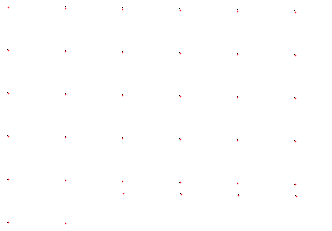

In [1]:
import torch
import numpy as np
import pylab as plt
from skimage import filters
import math

global numpoints
numpoints = 1
side = 32

rows = torch.zeros(32,32)
columns = torch.zeros(32,32)


for i in range(32):
    columns[:,i] = i
    rows[i,:] = i


def point_matrix():
    length = side**2
    canvas = torch.zeros((length,side, side))
    

    x = torch.zeros(length,numpoints) 
    y = torch.zeros(length,numpoints)
    assert x.shape == (length,numpoints)
    assert y.shape == (length,numpoints)
    
    points = torch.zeros(length,2)
    for j in range(side):
      for i in range(side):
        l = i*32+j
        canvas[l,i,j] = 1.0
        x[l] = i
        y[l] = j

        #points[l,:,0] = x[l,:]
        #points[l,:,1] = y[l,:]
        points[l,0] = i#modified for lstm discriminator
        points[l,1] = j#modified for lstm discriminator 
    
    
    return {
        'canvas': canvas, 
        'points':points.type(torch.FloatTensor)}


def plot_all( sample = None, model = None, labels = None):
    img = sample[:,:].squeeze().cpu().numpy()
    #img = np.zeros((32,32))
    #img[1,1] = 1
    #img[31,1] = 1
    #img[31,31] = 1
    img = img.T
    plt.imshow(img, cmap=plt.cm.gray_r)
    if model != None:
        with torch.no_grad():
            global numpoints

            print("sample", sample.shape)
            sample = sample.cuda()
            sample = sample.unsqueeze(0)
            print('hello',sample.shape)
            pred = model(sample)
            print('hello')
            
            print('pred', pred.shape)
            predres = 1
            X = pred[:,0]
            Y = pred[:,1]
            
            s = [10 for x in range(predres)]
            
            assert len(s) == predres
            c = ['red' for x in range(predres)]
            assert len(c) == predres
            Y = Y.cuda()
            X = X.cuda()
            print("type",type(X))
            ascatter = plt.scatter(X.cpu().numpy(),Y.cpu().numpy(),s = s,c = c)
            plt.gca().add_artist(ascatter)
    else:
        #print(labels.shape)

        X = labels[0]
        Y = labels[1]
        #print(X.shape)
        #print(Y.shape)
        print(X,Y)
        s = [.1 for x in range(numpoints)]
        #print(len(s))
        c = ['red' for x in range(numpoints)]
        #print(len(c))
        ascatter = plt.scatter(X,Y,s = s,c = c)
        plt.gca().add_artist(ascatter)

class PointDataset(torch.utils.data.Dataset):
    """Donut dataset."""
    def __init__(self):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.length = side**2
        self.values = point_matrix()
        assert self.values['canvas'].shape[0] == self.length
        assert self.values['points'].shape[0] == self.length

    def __len__(self):
        return self.length


    def __getitem__(self, idx):
        canvas = self.values["canvas"]
        
        canvas = canvas[idx,:,:]
        assert canvas.shape == (side,side)
        points = self.values["points"]
        points = points[idx,:]
        return canvas, points
    
    @staticmethod
    def displayCanvas(title,dataset, model):
        #model.setBatchSize(batch_size = 1)
        for i in range(36):
            sample, labels = dataset[i]
            plt.subplot(6,6,i+1)
            plot_all(sample = sample,model=model, labels = labels)
            plt.axis('off')
        plt.savefig(title,dpi=600)

dataset = PointDataset()
PointDataset.displayCanvas('donut.png',dataset, model = None)


In [2]:
d = dataset

In [3]:
l=2
c = d[l][0]
print(d[l][1][0],d[l][1][1])
i= (int)(d[l][1][0].item())
j=(int)(d[l][1][1].item())
print(i,j)

print(c[i,j])
print(d[l][1])
print(c)

tensor(0.) tensor(2.)
0 2
tensor(1.)
tensor([0., 2.])
tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [9]:
import torch
import torch.nn as nn
from torch.hub import load_state_dict_from_url

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.input_dim = 1*32*32
        self.hidden_dim = 2**11
        self.midl=1
        
        self.inLayer = nn.Sequential(
            nn.Linear(self.input_dim, (int)(self.input_dim/2)),
            nn.ReLU(True),
            nn.Dropout()
         )
        self.midLayers1 = nn.Sequential(
            nn.Linear((int)(self.input_dim/2)+self.input_dim, (int)(self.input_dim/4)),
            nn.ReLU(True),
            nn.Dropout()
        )        
        self.midLayers2 = nn.Sequential(
            nn.Linear((int)(self.input_dim/4)+self.input_dim, (int)(self.input_dim/8)),
            nn.ReLU(True),
            nn.Dropout()
        )        
        self.midLayers3 = nn.Sequential(
            nn.Linear((int)(self.input_dim/8)+self.input_dim, (int)(self.input_dim/16)),
            nn.ReLU(True),
            nn.Dropout()
        )        
        self.midLayers4 = nn.Sequential(
            nn.Linear((int)(self.input_dim/16)+self.input_dim, (int)(self.input_dim/32)),
            nn.ReLU(True),
            nn.Dropout()
        )        
        self.out_layer = nn.Sequential(
           nn.Linear((int)(self.input_dim/32)+self.input_dim, 2),
            nn.Sigmoid()
        )
        

    def forward(self, x):
        #x = x.squeeze()
        x = torch.flatten(x,start_dim=1)
        
        #assert x.shape == (mini_batch,self.hidden_dim)
        out = self.inLayer(x)
        
        out = torch.cat([out,x],dim = 1)
        out = self.midLayers1(out)
        
        out = torch.cat([out,x],dim = 1)
        out = self.midLayers2(out)
        
        out = torch.cat([out,x],dim = 1)
        out = self.midLayers3(out)

        out = torch.cat([out,x],dim = 1)
        out = self.midLayers4(out)
        
        out = torch.cat([out,x],dim = 1)
        out = self.out_layer(out)
        
        return 32.0*out


In [75]:
import torch
import torch.nn as nn
from torch.hub import load_state_dict_from_url

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.input_dim = 1*32*32
        self.hidden_dim = 2**11
        self.midl=1
        
        self.inLayer = nn.Sequential(
            nn.Linear(self.input_dim, (int)(self.input_dim/2)),
            nn.ReLU(True),
            nn.Dropout()
         )
        
        self.midLayers1 = nn.Sequential(
            nn.Linear((int)(self.input_dim/2), (int)(self.input_dim/4)),
            nn.ReLU(True),
            nn.Dropout()
        )

        self.skip2 = nn.Sequential(
            nn.Linear(self.input_dim, (int)(self.input_dim/2)),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear((int)(self.input_dim/2), (int)(self.input_dim/4)),
            nn.ReLU(True),
            nn.Dropout()
         ) 
        self.midLayers2 = nn.Sequential(
            nn.Linear((int)(self.input_dim/4), (int)(self.input_dim/8)),
            nn.ReLU(True),
            nn.Dropout()
        )       

        self.skip3 = nn.Sequential(
            nn.Linear(self.input_dim, (int)(self.input_dim/2)),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear((int)(self.input_dim/2), (int)(self.input_dim/4)),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear((int)(self.input_dim/4), (int)(self.input_dim/8)),
            nn.ReLU(True),
            nn.Dropout()
         )
        self.midLayers3 = nn.Sequential(
            nn.Linear((int)(self.input_dim/8), (int)(self.input_dim/16)),
            nn.ReLU(True),
            nn.Dropout()
        )

        self.skip4 = nn.Sequential(
            nn.Linear(self.input_dim, (int)(self.input_dim/2)),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear((int)(self.input_dim/2), (int)(self.input_dim/4)),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear((int)(self.input_dim/4), (int)(self.input_dim/8)),
            nn.ReLU(True),
            nn.Dropout(),
         
            nn.Linear((int)(self.input_dim/8), (int)(self.input_dim/16)),
            nn.ReLU(True),
            nn.Dropout()
         )
        self.midLayers4 = nn.Sequential(
            nn.Linear((int)(self.input_dim/16), (int)(self.input_dim/32)),
            nn.ReLU(True),
            nn.Dropout()
        )   

        self.skip5 = nn.Sequential(
            nn.Linear(self.input_dim, (int)(self.input_dim/2)),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear((int)(self.input_dim/2), (int)(self.input_dim/4)),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear((int)(self.input_dim/4), (int)(self.input_dim/8)),
            nn.ReLU(True),
            nn.Dropout(),
         
            nn.Linear((int)(self.input_dim/8), (int)(self.input_dim/16)),
            nn.ReLU(True),
            nn.Dropout(),
         
            nn.Linear((int)(self.input_dim/16), (int)(self.input_dim/32)),
            nn.ReLU(True),
            nn.Dropout()
         )
        
        
        self.midLayers5 = nn.Sequential(
            nn.Linear((int)(self.input_dim/32), (int)(self.input_dim/64)),
            nn.ReLU(True),
            nn.Dropout()
        )


        self.skip6 = nn.Sequential(
            nn.Linear(self.input_dim, (int)(self.input_dim/2)),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear((int)(self.input_dim/2), (int)(self.input_dim/4)),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear((int)(self.input_dim/4), (int)(self.input_dim/8)),
            nn.ReLU(True),
            nn.Dropout(),
         
            nn.Linear((int)(self.input_dim/8), (int)(self.input_dim/16)),
            nn.ReLU(True),
            nn.Dropout(),
         
            nn.Linear((int)(self.input_dim/16), (int)(self.input_dim/32)),
            nn.ReLU(True),
            nn.Dropout(),
         
            nn.Linear((int)(self.input_dim/32), (int)(self.input_dim/64)),
            nn.ReLU(True),
            nn.Dropout()
         )
        


        self.midLayers6 = nn.Sequential(
            nn.Linear((int)(self.input_dim/64), (int)(self.input_dim/128)),
            nn.ReLU(True),
            nn.Dropout()
        )   
           
        self.skipout = nn.Sequential(
            nn.Linear(self.input_dim, (int)(self.input_dim/128)),
            nn.ReLU(True),
            nn.Dropout()
         )
             
        self.out_layer = nn.Sequential(
           nn.Linear((int)(self.input_dim/128), 2),
            nn.Sigmoid()
        )
        

    def forward(self, x):
        #x = x.squeeze()
        x = torch.flatten(x,start_dim=1)
        
        #assert x.shape == (mini_batch,self.hidden_dim)
        out = self.inLayer(x)
        
        out = self.midLayers1(out)
        
        out += self.skip2(x)
        out = self.midLayers2(out)
        
        out += self.skip3(x)
        out = self.midLayers3(out)
        afterMid3 = out

        out+= self.skip4(x)
        out = self.midLayers4(out)
        
        out+= self.skip5(x)
        out = self.midLayers5(out)
        
        out+= self.skip6(x)
        out = self.midLayers6(out)
        
        out += self.skipout(x)
        out = self.out_layer(out)
        
        return 32.0*out


In [259]:
import torch
import torch.nn as nn
from torch.hub import load_state_dict_from_url

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.input_dim = 1*32*32
        self.hidden_dim = 2**11
        self.midl=1
        
        self.inLayer = nn.Sequential(
            nn.Linear(self.input_dim, (int)(self.input_dim/2)),
            nn.ReLU(True),
            nn.Dropout()
         )
        
        self.midLayers1 = nn.Sequential(
            nn.Linear((int)(self.input_dim/2), (int)(self.input_dim/4)),
            nn.ReLU(True),
            nn.Dropout()
        )
        self.midLayers2 = nn.Sequential(
            nn.Linear((int)(self.input_dim/4), (int)(self.input_dim/8)),
            nn.ReLU(True),
            nn.Dropout()
        )

        
        self.up1 = nn.Sequential(
            nn.Linear((int)(self.input_dim/8), (int)(self.input_dim/4)),
            nn.ReLU(True),
            nn.Dropout()
        )

        self.up2 = nn.Sequential(
            nn.Linear((int)(self.input_dim/4), (int)(self.input_dim/2)),
            nn.ReLU(True),
            nn.Dropout()
        )
        self.up3 = nn.Sequential(
            nn.Linear((int)(self.input_dim/2), (int)(self.input_dim)),
            nn.ReLU(True),
            nn.Dropout()
        )

        self.down1 = nn.Sequential(
            nn.Linear((int)(self.input_dim), (int)(self.input_dim/2)),
            nn.ReLU(True),
            nn.Dropout()
        )
        self.down2 = nn.Sequential(
            nn.Linear((int)(self.input_dim/2), (int)(self.input_dim/4)),
            nn.ReLU(True),
            nn.Dropout()
        )
        self.out_layer = nn.Sequential(
          nn.Linear((int)(self.input_dim/4), 2),
            nn.Sigmoid()
        )

        self.skip1 = nn.Sequential(
         nn.Linear((int)(self.input_dim), (int)(self.input_dim)),
            nn.ReLU(True),
            nn.Dropout()
        )

        self.skip2 = nn.Sequential(
         nn.Linear((int)(self.input_dim/2), (int)(self.input_dim/2)),
            nn.ReLU(True),
            nn.Dropout()
        )

        self.skip4 = nn.Sequential(
         nn.Linear((int)(self.input_dim/4), (int)(self.input_dim/4)),
            nn.ReLU(True),
            nn.Dropout()
        )

        self.skip8 = nn.Sequential(
         nn.Linear((int)(self.input_dim/8), (int)(self.input_dim/8)),
            nn.ReLU(True),
            nn.Dropout()
        )

    def forward(self, x):
        #x = x.squeeze()
        x = torch.flatten(x,start_dim=1)
        
        #assert x.shape == (mini_batch,self.hidden_dim)
        out = self.inLayer(x)
        afterIn = out
        out = self.midLayers1(out)
        afterml1 = out
        out = self.midLayers2(out)
        afterml2 = out        
        out = self.up1(out)
        out+= self.skip4(afterml1)
        out = self.up2(out)
        out+= self.skip2(afterIn)
        out = self.up3(out)
        
        out += self.skip1(x)
        out = self.down1(out)
         
        out = self.down2(out)
        
        out = self.out_layer(out)
        
        return 32.0*out

In [209]:
import torch
import torch.nn as nn
from torch.hub import load_state_dict_from_url

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.input_dim = 1*32*32 #2**10
        self.hidden_dim = 2**11
        self.midl=1
        assert self.input_dim ==2**10
        self.downLayer = [nn.Sequential(
            nn.Linear((int)(self.input_dim/2**i), (int)(self.input_dim/2**(i+1))),
            nn.ReLU(True),
            nn.Dropout()
         ).cuda() for i in range(9)]
        

        self.upLayer = [nn.Sequential(
            nn.Linear((int)(self.input_dim/2**(i+1)), (int)(self.input_dim/2**(i))),
            nn.ReLU(True),
            nn.Dropout()
         ).cuda() for i in range(8,-1,-1)]
        
        self.finalDown = [nn.Sequential(
            nn.Linear((int)(self.input_dim/2**i), (int)(self.input_dim/2**(i+1))),
            nn.ReLU(True),
            nn.Dropout()
         ).cuda() for i in range(9)]

        self.skip1 = [nn.Sequential(
            nn.Linear((int)(self.input_dim/2**i), (int)(self.input_dim/2**i)),
            nn.ReLU(True),
            nn.Dropout()
         ).cuda() for i in range(9,-1,-1)]

        self.skip2 = [nn.Sequential(
            nn.Linear((int)(self.input_dim/2**i), (int)(self.input_dim/2**i)),
            nn.ReLU(True),
            nn.Dropout()
         ).cuda() for i in range(10)]

        self.downLayer = nn.Sequential(*self.downLayer)
        self.upLayer = nn.Sequential(*self.upLayer)
        self.finalDown = nn.Sequential(*self.finalDown)
        
    def forward(self, x):
      x = torch.flatten(x,start_dim=1)
      out = x
      p1 = [x]
      for i in range(9):
        out = self.downLayer[i](out)
        p1.append(out)
      
      p1.reverse()
      p2 = []
      
      for i in range(9):
        out+=p1[i] 
        out = self.upLayer[i](out)
        p2.append(out)
      
      p2.reverse()
      for i in range(9):
        out+=p2[i]
        out = self.finalDown[i](out)
        
      #print('done', out.shape)
      return out

In [284]:
import torch
import torch.nn as nn
from torch.hub import load_state_dict_from_url

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.input_dim = 1*32*32 #2**10
        self.hidden_dim = 2**11
        self.midl=1
        assert self.input_dim ==2**10
        self.downLayer = [nn.Sequential(
            nn.Linear((int)(self.input_dim/2**i), (int)(self.input_dim/2**(i+1))),
            nn.ReLU(True),
            nn.Dropout()
         ).cuda() for i in range(9)]
        

        self.upLayer = [nn.Sequential(
            nn.Linear((int)(self.input_dim/2**(i+1)), (int)(self.input_dim/2**(i))),
            nn.ReLU(True),
            nn.Dropout()
         ).cuda() for i in range(8,-1,-1)]
        
        self.finalDown = [nn.Sequential(
            nn.Linear((int)(self.input_dim/2**i), (int)(self.input_dim/2**(i+1))),
            nn.ReLU(True),
            nn.Dropout()
         ).cuda() for i in range(9)]

        self.skip1 = [nn.Sequential(
            nn.Linear((int)(self.input_dim/2**i), (int)(self.input_dim/2**i)),
            nn.ReLU(True),
            nn.Dropout()
         ).cuda() for i in range(9,-1,-1)]

        self.skip2 = [nn.Sequential(
            nn.Linear((int)(self.input_dim/2**i), (int)(self.input_dim/2**i)),
            nn.ReLU(True),
            nn.Dropout()
         ).cuda() for i in range(10)]

        self.downLayer = nn.Sequential(*self.downLayer)
        self.upLayer = nn.Sequential(*self.upLayer)
        self.finalDown = nn.Sequential(*self.finalDown)
        
    def forward(self, x):
      x = torch.flatten(x,start_dim=1)
      out = x
      p1 = [x]
      for i in range(9):
        out = self.downLayer[i](out)
        p1.append(out)
      
      p1.reverse()
      p2 = []
      
      for i in range(9):
        #out+=self.skip1[i](p1[i]) 
        out = self.upLayer[i](out)
        p2.append(out)
      p2.reverse()
      
      for i in range(9):
        #print(i)
        #out+=p2[i]
        out = self.finalDown[i](out)
        
      #print('done', out.shape)
      return out

In [285]:
model = MLP().cuda()

In [286]:
optimizer = torch.optim.Adam(model.parameters(),lr = 0.00001, betas = (.9,.999))

In [287]:
from torch.utils import data
from torch.utils.data import DataLoader, TensorDataset, RandomSampler

mini_batch = 128
dataset = PointDataset()
loader_train = data.DataLoader(
    dataset, 
    batch_size=mini_batch,
    sampler=RandomSampler(data_source=dataset),
    num_workers=4)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [288]:
epoch = 200
for e in range(epoch):
  for xin,yin in loader_train:
    if xin.shape[0] != mini_batch:
      print(xin.shape)
      continue
    xin = xin.cuda()
    yin = yin.cuda()
    out = model(xin)
    loss = torch.mean((out-yin)**2)
    loss.backward()
    optimizer.step()


  print(e,'\t', loss)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0 	 tensor(312.5000, device='cuda:0', grad_fn=<MeanBackward0>)
1 	 tensor(318.1172, device='cuda:0', grad_fn=<MeanBackward0>)
2 	 tensor(358.8281, device='cuda:0', grad_fn=<MeanBackward0>)
3 	 tensor(329.0391, device='cuda:0', grad_fn=<MeanBackward0>)
4 	 tensor(328.2461, device='cuda:0', grad_fn=<MeanBackward0>)
5 	 tensor(322.8750, device='cuda:0', grad_fn=<MeanBackward0>)
6 	 tensor(297.1172, device='cuda:0', grad_fn=<MeanBackward0>)
7 	 tensor(313.6953, device='cuda:0', grad_fn=<MeanBackward0>)
8 	 tensor(278.1836, device='cuda:0', grad_fn=<MeanBackward0>)
9 	 tensor(308.7734, device='cuda:0', grad_fn=<MeanBackward0>)
10 	 tensor(314.1875, device='cuda:0', grad_fn=<MeanBackward0>)
11 	 tensor(326.8867, device='cuda:0', grad_fn=<MeanBackward0>)
12 	 tensor(310.1250, device='cuda:0', grad_fn=<MeanBackward0>)
13 	 tensor(353.1328, device='cuda:0', grad_fn=<MeanBackward0>)
14 	 tensor(306.8516, device='cuda:0', grad_fn=<MeanBackward0>)


Exception ignored in: <function _releaseLock at 0x7fb821f228c0>
Traceback (most recent call last):
  File "/usr/lib/python3.7/logging/__init__.py", line 221, in _releaseLock
    def _releaseLock():
KeyboardInterrupt


RuntimeError: ignored

In [ ]:
dataset = PointDataset()
PointDataset.displayCanvas('donut.png',dataset, model = model)


In [ ]:
a= torch.zeros(64,3)
b = torch.zeros(64,4)
c = torch.cat([a,b], dim = 1)
print(c.shape)